## 机器学习策略——基于逻辑回归的股市趋势预测(及SVM策略)

In [1]:
%matplotlib inline
import seaborn
import matplotlib as mpl
mpl.rcParams['font.family'] = 'serif'
import warnings; warnings.simplefilter('ignore') #忽略可能会出现的警告信息，警告并不是错误，可以忽略；

### 1. 数据获取

In [2]:
import pandas as pd
import numpy as np
import tushare as ts

In [3]:
hs300 = ts.get_k_data('hs300', start = '2013-01-01', end = '2016-06-25')   #训练集数据

In [4]:
hs300.set_index('date', inplace = True)

In [5]:
hs300['returns'] = hs300['close'].pct_change()

In [6]:
hs300.dropna(inplace=True)            #有NaN值的话会影响机器学习算法；

In [7]:
hs300.head()

,open,close,high,low,volume,code,returns
date,,,,,,,
2013-01-07,2518.05,2535.99,2545.97,2511.60,75167993.0,hs300,0.004587
2013-01-08,2534.65,2525.33,2540.51,2502.49,71837100.0,hs300,-0.004203
2013-01-09,2518.10,2526.13,2534.24,2504.30,70231170.0,hs300,0.000317
2013-01-10,2525.59,2530.57,2553.35,2513.73,71085862.0,hs300,0.001758
2013-01-11,2533.50,2483.23,2539.79,2473.70,74239176.0,hs300,-0.018707


### 2. 数据处理——特征工程处理

In [8]:
#特征的生成；
for i in range(1, 8, 1):
    hs300['close - ' + str(i) + 'd'] = hs300['close'].shift(i)

In [9]:
hs300.head(8)

,open,close,high,low,volume,code,returns,close - 1d,close - 2d,close - 3d,close - 4d,close - 5d,close - 6d,close - 7d
date,,,,,,,,,,,,,,
2013-01-07,2518.05,2535.99,2545.97,2511.60,75167993.0,hs300,0.004587,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-08,2534.65,2525.33,2540.51,2502.49,71837100.0,hs300,-0.004203,2535.99,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-09,2518.10,2526.13,2534.24,2504.30,70231170.0,hs300,0.000317,2525.33,2535.99,NaN,NaN,NaN,NaN,NaN
2013-01-10,2525.59,2530.57,2553.35,2513.73,71085862.0,hs300,0.001758,2526.13,2525.33,2535.99,NaN,NaN,NaN,NaN
2013-01-11,2533.50,2483.23,2539.79,2473.70,74239176.0,hs300,-0.018707,2530.57,2526.13,2525.33,2535.99,NaN,NaN,NaN
2013-01-14,2474.18,2577.73,2583.62,2474.00,93554091.0,hs300,0.038055,2483.23,2530.57,2526.13,2525.33,2535.99,NaN,NaN
2013-01-15,2579.13,2595.86,2605.41,2576.92,98620805.0,hs300,0.007033,2577.73,2483.23,2530.57,2526.13,2525.33,2535.99,NaN
2013-01-16,2591.36,2577.09,2600.09,2540.52,93536084.0,hs300,-0.007231,2595.86,2577.73,2483.23,2530.57,2526.13,2525.33,2535.99


In [10]:
hs_7d = hs300[[x for x in hs300.columns if 'close' in x]].iloc[7:]   #从第八行开始没有NaN地方开始取值作为features

In [11]:
hs_7d.head(10)

,close,close - 1d,close - 2d,close - 3d,close - 4d,close - 5d,close - 6d,close - 7d
date,,,,,,,,
2013-01-16,2577.09,2595.86,2577.73,2483.23,2530.57,2526.13,2525.33,2535.99
2013-01-17,2552.76,2577.09,2595.86,2577.73,2483.23,2530.57,2526.13,2525.33
2013-01-18,2595.44,2552.76,2577.09,2595.86,2577.73,2483.23,2530.57,2526.13
2013-01-21,2610.90,2595.44,2552.76,2577.09,2595.86,2577.73,2483.23,2530.57
2013-01-22,2596.90,2610.90,2595.44,2552.76,2577.09,2595.86,2577.73,2483.23
2013-01-23,2607.46,2596.90,2610.90,2595.44,2552.76,2577.09,2595.86,2577.73
2013-01-24,2582.75,2607.46,2596.90,2610.90,2595.44,2552.76,2577.09,2595.86
2013-01-25,2571.67,2582.75,2607.46,2596.90,2610.90,2595.44,2552.76,2577.09
2013-01-28,2651.86,2571.67,2582.75,2607.46,2596.90,2610.90,2595.44,2552.76


In [12]:
import sklearn
from sklearn import linear_model

In [13]:
X_train = hs_7d
X_train = sklearn.preprocessing.scale(X_train)    #对features进行标准化；
X_train

array([[-0.48980854, -0.46439863, -0.48725682, ..., -0.5517547 ,
        -0.55179916, -0.53688237],
       [-0.52169806, -0.48899784, -0.46349906, ..., -0.54593936,
        -0.55075152, -0.55084015],
       [-0.46575704, -0.52088377, -0.48809548, ..., -0.60794343,
        -0.54493708, -0.54979267],
       ..., 
       [ 0.24008548,  0.20458992,  0.2137346 , ...,  0.22131846,
         0.1693086 ,  0.15753698],
       [ 0.2182753 ,  0.2408138 ,  0.20541349, ...,  0.19289665,
         0.22220162,  0.17015921],
       [ 0.16563726,  0.21900608,  0.24163326, ...,  0.2134468 ,
         0.19378422,  0.22304428]])

### 3. 逻辑回归预测股价趋势算法实现

In [14]:
lm = linear_model.LogisticRegression(C=1000)

In [15]:
# 计算出训练集的labels；
y_train = np.sign(hs_7d['close'].pct_change().shift(-1))       #非常重要；拿到下一天的收益，用.shift(-1)
y_train.replace(to_replace= np.NaN, value = 0,inplace = True)
y_train = y_train.reshape(-1,1)
y_train[-10:]

array([[ 1.],
       [ 1.],
       [-1.],
       [ 1.],
       [ 1.],
       [-1.],
       [ 1.],
       [-1.],
       [-1.],
       [ 0.]])

In [16]:
lm.fit(X_train, y_train)

LogisticRegression(C=1000, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [17]:
lm.score(X_train, y_train)

0.54610778443113772

In [18]:
hs300['prediction'] = np.NaN
hs300['prediction'].ix[7:] = lm.predict(X_train)    #返回的是我预测的训练集的labels；

In [28]:
hs300.head(10)

,open,close,high,low,volume,code,returns,close - 1d,close - 2d,close - 3d,close - 4d,close - 5d,close - 6d,close - 7d,prediction
date,,,,,,,,,,,,,,,
2013-01-07,2518.05,2535.99,2545.97,2511.60,75167993.0,hs300,0.004587,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-08,2534.65,2525.33,2540.51,2502.49,71837100.0,hs300,-0.004203,2535.99,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-09,2518.10,2526.13,2534.24,2504.30,70231170.0,hs300,0.000317,2525.33,2535.99,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-10,2525.59,2530.57,2553.35,2513.73,71085862.0,hs300,0.001758,2526.13,2525.33,2535.99,NaN,NaN,NaN,NaN,NaN
2013-01-11,2533.50,2483.23,2539.79,2473.70,74239176.0,hs300,-0.018707,2530.57,2526.13,2525.33,2535.99,NaN,NaN,NaN,NaN
2013-01-14,2474.18,2577.73,2583.62,2474.00,93554091.0,hs300,0.038055,2483.23,2530.57,2526.13,2525.33,2535.99,NaN,NaN,NaN
2013-01-15,2579.13,2595.86,2605.41,2576.92,98620805.0,hs300,0.007033,2577.73,2483.23,2530.57,2526.13,2525.33,2535.99,NaN,NaN
2013-01-16,2591.36,2577.09,2600.09,2540.52,93536084.0,hs300,-0.007231,2595.86,2577.73,2483.23,2530.57,2526.13,2525.33,2535.99,-1.0
2013-01-17,2570.71,2552.76,2575.06,2539.67,69915239.0,hs300,-0.009441,2577.09,2595.86,2577.73,2483.23,2530.57,2526.13,2525.33,1.0


In [29]:
hs300['prediction'].value_counts()

 1.0    572
-1.0    263
Name: prediction, dtype: int64

In [32]:
hs300['strategy'] = (hs300['prediction'].shift(1) * hs300['returns'] + 1).cumprod()
hs300['cum_ret'] = (hs300['returns']+1).cumprod()

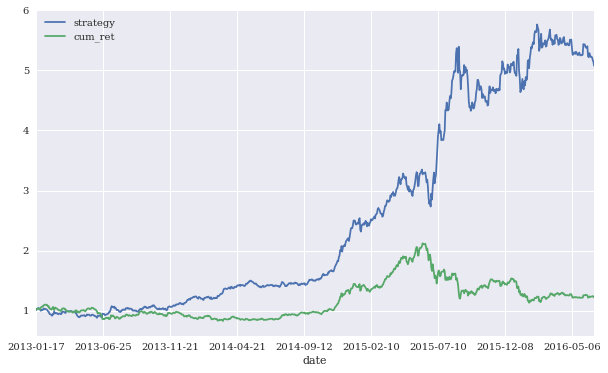

In [33]:
hs300[['strategy','cum_ret']].dropna().plot(figsize=(10, 6))

### 4. 改变算法：SVM

In [34]:
X_train = hs_7d

In [35]:
from sklearn.svm import SVC
clf_SVC = SVC(kernel = 'linear')

In [36]:
clf_SVC.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [37]:
clf_SVC.score(X_train, y_train)

0.52814371257485027

In [38]:
hs300['prediction'] = np.NaN
hs300['prediction'].ix[7:] = clf_SVC.predict(X_train)

In [40]:
hs300['strategy'] = (hs300['prediction'].shift(1) * hs300['returns'] + 1).cumprod()
hs300['cum_ret'] = (hs300['returns']+1).cumprod()

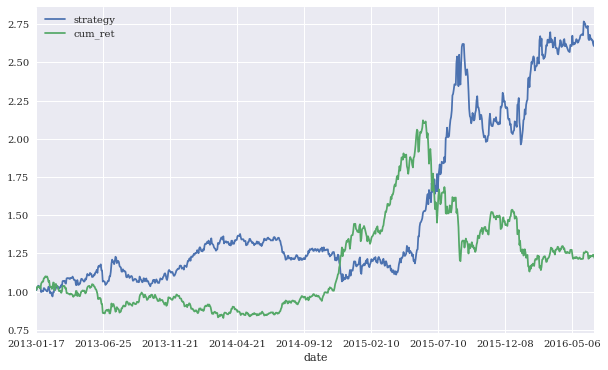

In [41]:
hs300[['strategy','cum_ret']].dropna().plot(figsize=(10, 6))

### 5. 逻辑回归算法在测试集的验证

In [42]:
hs300_test = ts.get_k_data('hs300', start = '2016-07-01', end = '2017-06-30')      #测试集数据

In [43]:
hs300_test.set_index('date', inplace = True)

In [44]:
hs300_test['returns'] = hs300_test['close'].pct_change()

In [45]:
hs300_test.dropna(inplace=True)

In [46]:
hs300_test.head()

,open,close,high,low,volume,code,returns
date,,,,,,,
2016-07-04,3136.39,3204.70,3210.60,3134.02,133310529.0,hs300,0.016010
2016-07-05,3199.16,3207.38,3216.70,3198.00,130226895.0,hs300,0.000836
2016-07-06,3197.62,3216.80,3217.51,3183.45,124897458.0,hs300,0.002937
2016-07-07,3206.55,3209.95,3220.54,3190.12,118595202.0,hs300,-0.002129
2016-07-08,3199.75,3192.28,3204.93,3183.96,89734855.0,hs300,-0.005505


In [47]:
for i in range(1, 8, 1):
    hs300_test['close - ' + str(i) + 'd'] = hs300_test['close'].shift(i)

In [48]:
hs300_test.head()

,open,close,high,low,volume,code,returns,close - 1d,close - 2d,close - 3d,close - 4d,close - 5d,close - 6d,close - 7d
date,,,,,,,,,,,,,,
2016-07-04,3136.39,3204.70,3210.60,3134.02,133310529.0,hs300,0.016010,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-07-05,3199.16,3207.38,3216.70,3198.00,130226895.0,hs300,0.000836,3204.70,NaN,NaN,NaN,NaN,NaN,NaN
2016-07-06,3197.62,3216.80,3217.51,3183.45,124897458.0,hs300,0.002937,3207.38,3204.70,NaN,NaN,NaN,NaN,NaN
2016-07-07,3206.55,3209.95,3220.54,3190.12,118595202.0,hs300,-0.002129,3216.80,3207.38,3204.70,NaN,NaN,NaN,NaN
2016-07-08,3199.75,3192.28,3204.93,3183.96,89734855.0,hs300,-0.005505,3209.95,3216.80,3207.38,3204.7,NaN,NaN,NaN


In [49]:
hs_7d_test = hs300_test[[x for x in hs300_test.columns if 'close' in x]].iloc[7:]

In [50]:
hs_7d_test.head()

,close,close - 1d,close - 2d,close - 3d,close - 4d,close - 5d,close - 6d,close - 7d
date,,,,,,,,
2016-07-13,3282.87,3273.18,3203.33,3192.28,3209.95,3216.80,3207.38,3204.70
2016-07-14,3276.76,3282.87,3273.18,3203.33,3192.28,3209.95,3216.80,3207.38
2016-07-15,3276.28,3276.76,3282.87,3273.18,3203.33,3192.28,3209.95,3216.80
2016-07-18,3262.02,3276.28,3276.76,3282.87,3273.18,3203.33,3192.28,3209.95
2016-07-19,3248.23,3262.02,3276.28,3276.76,3282.87,3273.18,3203.33,3192.28


In [51]:
X_test = hs_7d_test 
X_test = sklearn.preprocessing.scale(X_test)
X_test

array([[-1.08385111, -1.17718366, -1.86756869, ..., -1.72317764,
        -1.81302459, -1.82902805],
       [-1.14374922, -1.08098366, -1.16789687, ..., -1.79379777,
        -1.71531841, -1.80115087],
       [-1.1484548 , -1.14164228, -1.0708343 , ..., -1.97596677,
        -1.78636802, -1.70316467],
       ..., 
       [ 2.47768481,  2.80920961,  2.78782826, ...,  2.10329928,
         1.7042943 ,  1.80093442],
       [ 2.6998274 ,  2.52577203,  2.85423948, ...,  2.12783591,
         2.1344297 ,  1.72624855],
       [ 2.67992672,  2.7507351 ,  2.56826052, ...,  2.46330729,
         2.15911555,  2.1576167 ]])

In [52]:
hs300_test['prediction'] = np.NaN
hs300_test['prediction'].ix[7:] = lm.predict(X_test)    #给你测试集的features，返回的是预测的测试集的labels

In [53]:
hs300_test['prediction'].value_counts()

 1.0    135
-1.0    100
Name: prediction, dtype: int64

In [55]:
hs300_test.head(10)

,open,close,high,low,volume,code,returns,close - 1d,close - 2d,close - 3d,close - 4d,close - 5d,close - 6d,close - 7d,prediction
date,,,,,,,,,,,,,,,
2016-07-04,3136.39,3204.70,3210.60,3134.02,133310529.0,hs300,0.016010,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-07-05,3199.16,3207.38,3216.70,3198.00,130226895.0,hs300,0.000836,3204.70,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-07-06,3197.62,3216.80,3217.51,3183.45,124897458.0,hs300,0.002937,3207.38,3204.70,NaN,NaN,NaN,NaN,NaN,NaN
2016-07-07,3206.55,3209.95,3220.54,3190.12,118595202.0,hs300,-0.002129,3216.80,3207.38,3204.70,NaN,NaN,NaN,NaN,NaN
2016-07-08,3199.75,3192.28,3204.93,3183.96,89734855.0,hs300,-0.005505,3209.95,3216.80,3207.38,3204.70,NaN,NaN,NaN,NaN
2016-07-11,3199.04,3203.33,3235.96,3197.62,138529511.0,hs300,0.003461,3192.28,3209.95,3216.80,3207.38,3204.70,NaN,NaN,NaN
2016-07-12,3201.91,3273.18,3273.47,3200.30,172534217.0,hs300,0.021805,3203.33,3192.28,3209.95,3216.80,3207.38,3204.70,NaN,NaN
2016-07-13,3274.02,3282.87,3300.99,3271.77,175196090.0,hs300,0.002960,3273.18,3203.33,3192.28,3209.95,3216.80,3207.38,3204.70,-1.0
2016-07-14,3277.48,3276.76,3281.95,3259.06,107525798.0,hs300,-0.001861,3282.87,3273.18,3203.33,3192.28,3209.95,3216.80,3207.38,-1.0


In [62]:
hs300_test['strategy'] = (hs300_test['prediction'].shift(1) * hs300_test['returns'] + 1).cumprod()
hs300_test['cum_ret'] = (hs300_test['returns']+1).cumprod()

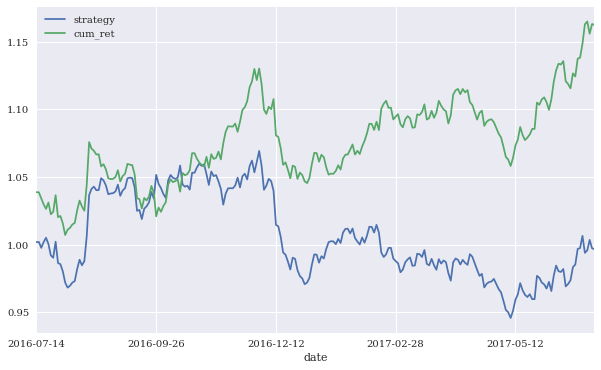

In [63]:
hs300_test[['strategy','cum_ret']].dropna().plot(figsize=(10, 6))

### 6.SVM算法在测试集的验证

In [58]:
X_test = hs_7d_test 

In [59]:
hs300_test['prediction'] = np.NaN
hs300_test['prediction'].ix[7:] = clf_SVC.predict(X_test)

In [64]:
hs300_test['strategy'] = (hs300_test['prediction'].shift(1) * hs300_test['returns'] + 1).cumprod()
hs300_test['cum_ret'] = (hs300_test['returns']+1).cumprod()

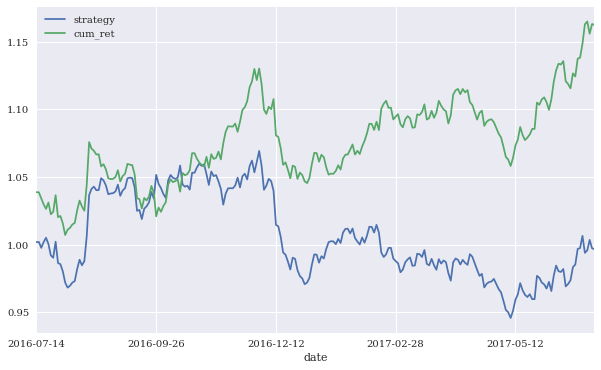

In [65]:
hs300_test[['strategy','cum_ret']].dropna().plot(figsize=(10, 6))

声明：本资料仅供内部学习交流使用，切勿外传。